### Extracting annotations from XML file

In [7]:
import os
import xml.etree.ElementTree as ET
import numpy as np

xml_root_dir = "LIDC-XML-only"

def extract_annotations(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    namespace = {'ns': 'http://www.nih.gov'}
    annotations_dict = {}
    reading_sessions = root.findall('.//ns:readingSession', namespace)
    for reading_session in reading_sessions:
        for unblinded_read_nodule in reading_session.findall('.//ns:unblindedReadNodule', namespace):
            nodule_id = unblinded_read_nodule.find('ns:noduleID', namespace).text
            characteristics = unblinded_read_nodule.find('ns:characteristics', namespace)
            characteristics_dict = {}
            if characteristics is not None:
                for characteristic in characteristics:
                    characteristics_dict[characteristic.tag.split('}')[1]] = int(characteristic.text)
            else:
                continue
            for roi in unblinded_read_nodule.findall('.//ns:roi', namespace):
                image_sop_uid = roi.find('ns:imageSOP_UID', namespace).text
                edge_map = []
                for edge in roi.findall('.//ns:edgeMap', namespace):
                    x_coord = int(edge.find('ns:xCoord', namespace).text)
                    y_coord = int(edge.find('ns:yCoord', namespace).text)
                    edge_map.append((x_coord, y_coord))
                if image_sop_uid not in annotations_dict:
                    annotations_dict[image_sop_uid] = []
                annotation = {
                    'nodule_id': nodule_id,
                    'edge_map': edge_map
                }
                if characteristics_dict:
                    annotation['characteristics'] = characteristics_dict
                annotations_dict[image_sop_uid].append(annotation)
    return annotations_dict

all_annotations = {}

for subdir, _, files in os.walk(xml_root_dir):
    for file in files:
        if file.endswith(".xml"):
            xml_file_path = os.path.join(subdir, file)
            annotations = extract_annotations(xml_file_path)
            for uid, annotation in annotations.items():
                if uid not in all_annotations:
                    all_annotations[uid] = []
                all_annotations[uid].extend(annotation)

### LIDC-IDRI images without windowing and with windowing

In [8]:
def apply_windowing(dicom_img, window_level, window_width):
    # Convert pixel data from DICOM to Hounsfield Units (HU)
    hu_image = dicom_img.pixel_array * dicom_img.RescaleSlope + dicom_img.RescaleIntercept
    
    # Apply windowing
    min_hu = window_level - window_width / 2
    max_hu = window_level + window_width / 2
    windowed_image = np.clip(hu_image, min_hu, max_hu)

    # Normalize to 0-255 grayscale
    windowed_image = (windowed_image - min_hu) / (max_hu - min_hu) * 255.0
    return windowed_image

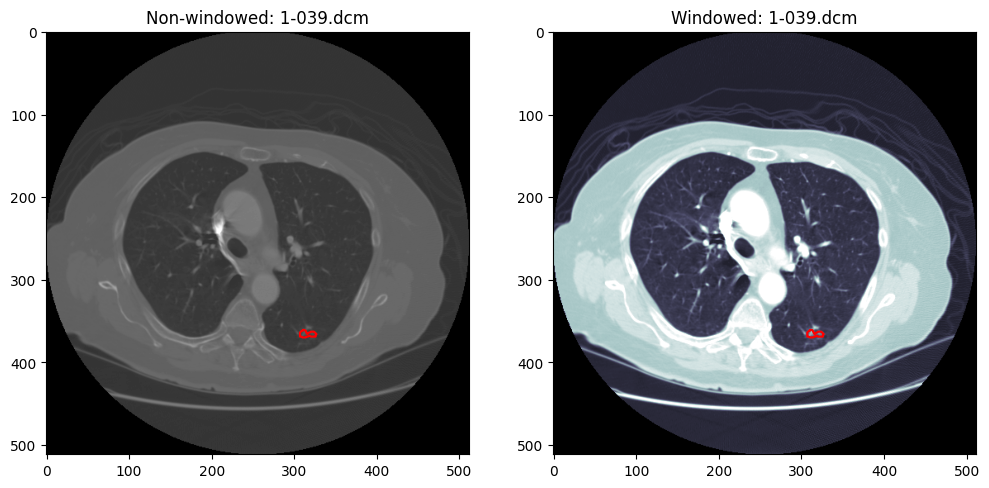

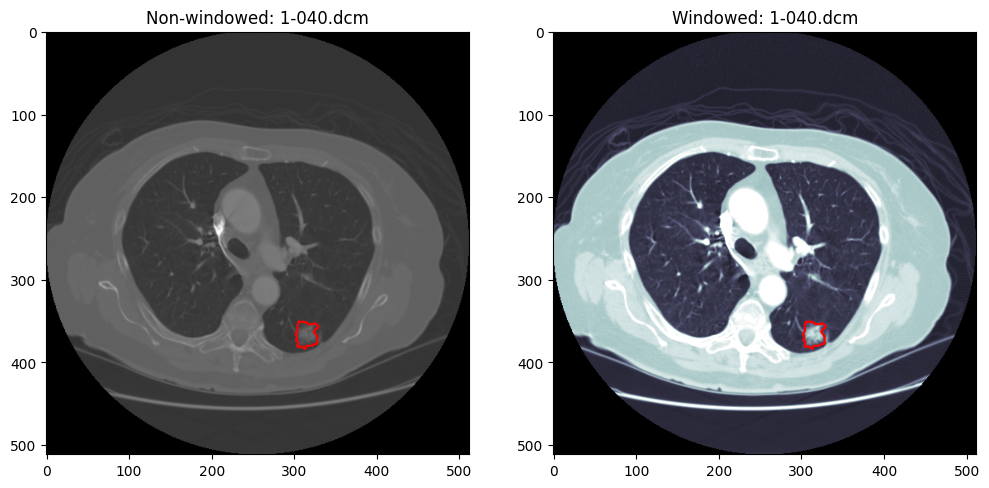

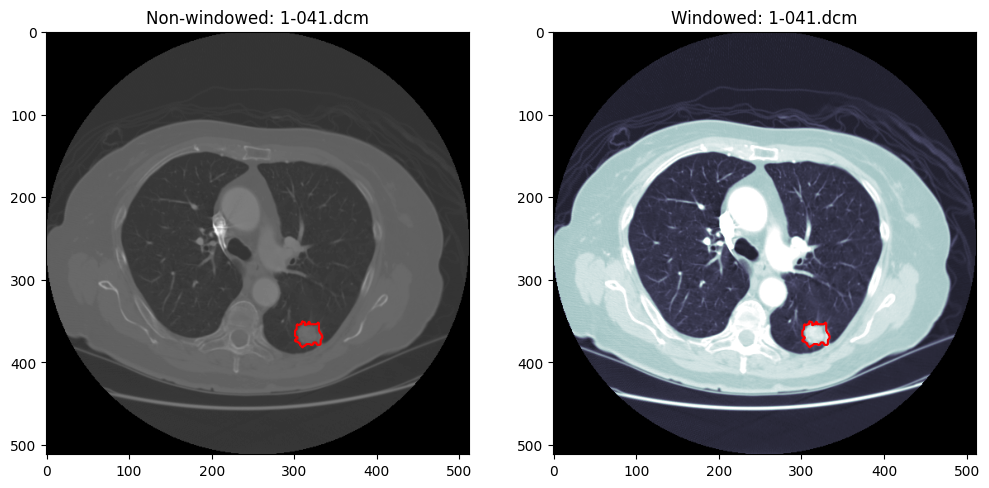

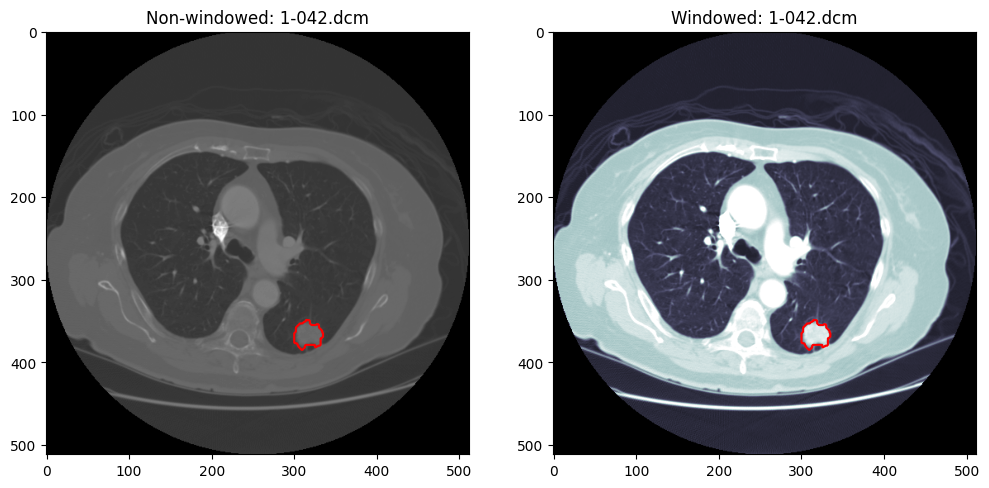

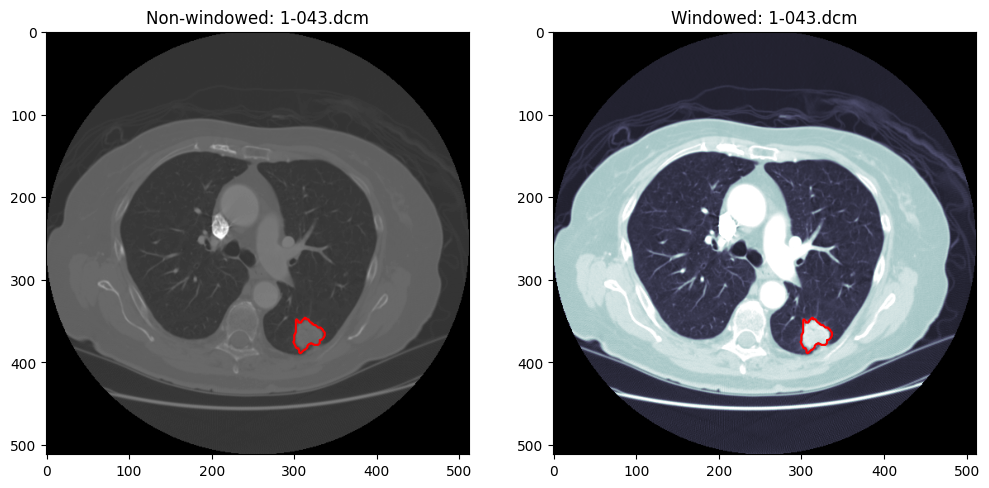

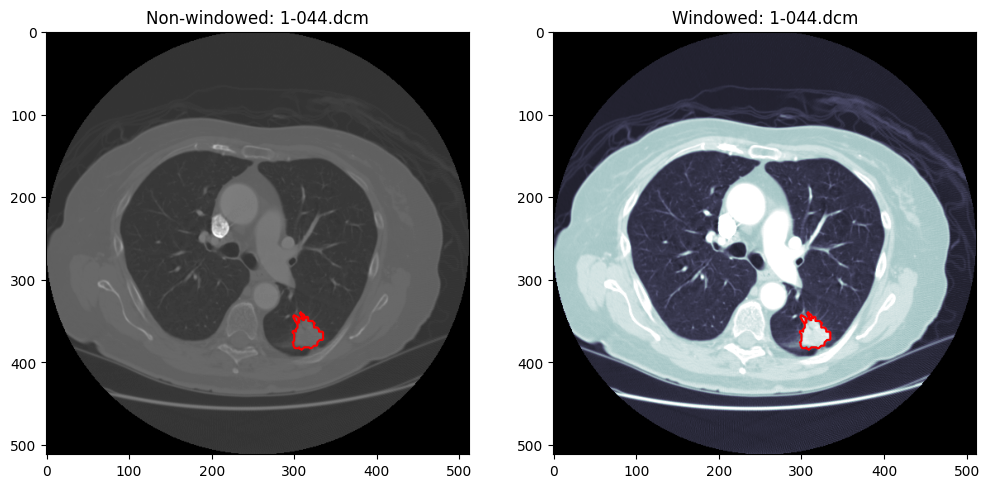

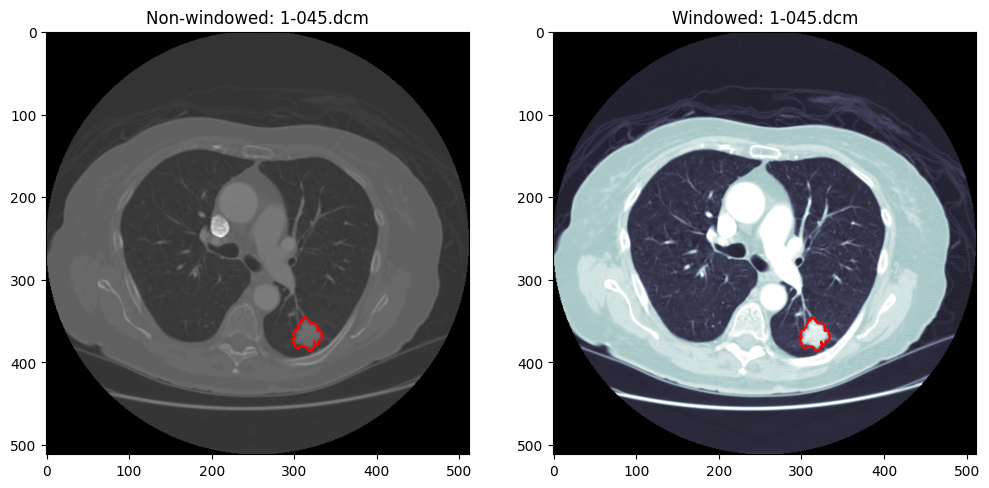

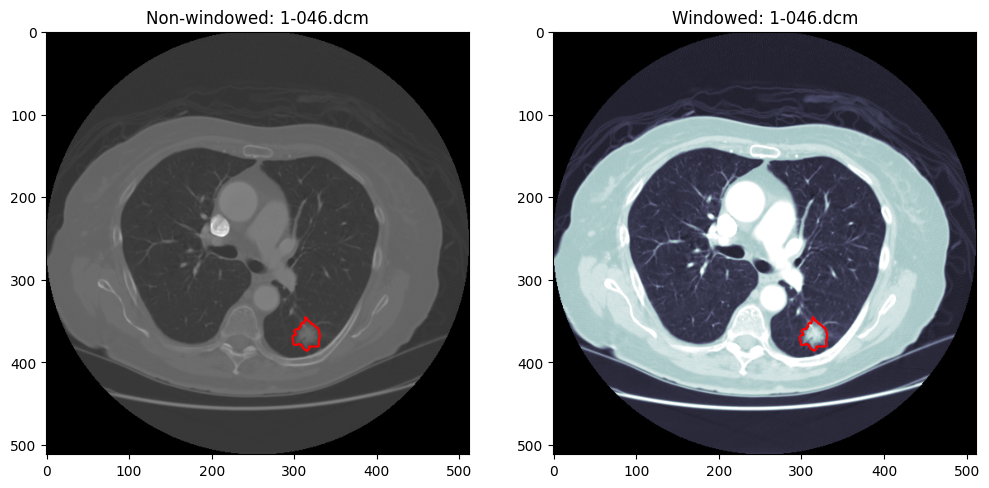

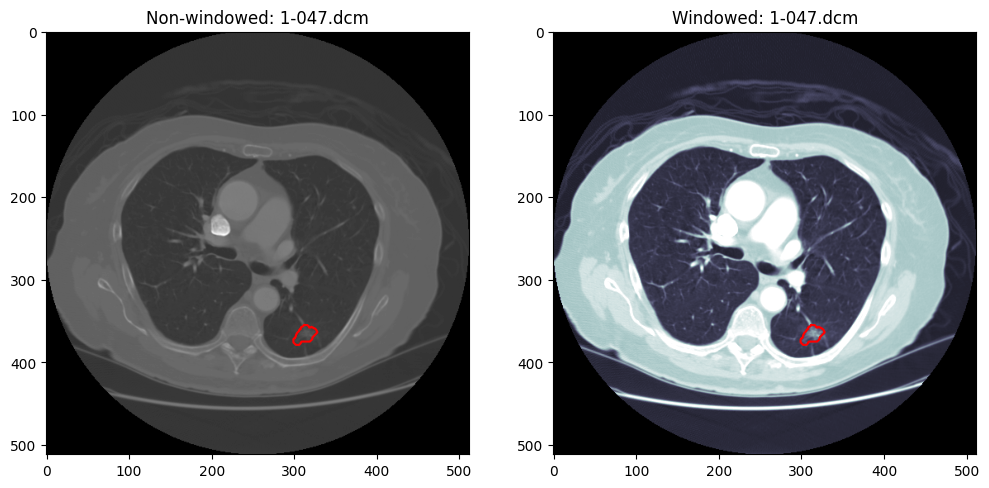

In [10]:
import os
import pydicom
import matplotlib.pyplot as plt

root_dir = "manifest-1600709154662\LIDC-IDRI\LIDC-IDRI-0001"

for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith(".dcm"):
            file_path = os.path.join(subdir, file)
            
            dcm = pydicom.dcmread(file_path)
            if hasattr(dcm, 'PixelData'):
                pixel_array = dcm.pixel_array
                pixel_array_windowed = apply_windowing(dcm, -500, 1500)
                uid = dcm.SOPInstanceUID
                if uid in all_annotations:
                    if pixel_array.ndim > 2:
                        pixel_array = pixel_array[0]
                        pixel_array_windowed = pixel_array_windowed[0]
                    
                    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
                    
                    axes[0].imshow(pixel_array, cmap=plt.cm.gray)
                    axes[0].set_title(f"Non-windowed: {file}")
                    edge_points = all_annotations[uid][0]['edge_map']
                    x, y = zip(*edge_points)
                    axes[0].plot(x, y, 'r-')
                    
                    axes[1].imshow(pixel_array_windowed, cmap=plt.cm.bone)
                    axes[1].set_title(f"Windowed: {file}")
                    axes[1].plot(x, y, 'r-')
                    
                    plt.show()
            else:
                print(f"No pixel data in file: {file_path}")